## Name: Maharsh Raval
## Roll No.: 210108026

# Feature Visualization: Interpretation How Neural Network Understands Images

What if we could peek inside a neural network and actually see what it’s paying attention to when it looks at an image?

That’s what feature visualization helps us do. In simple terms, it’s a way to understand how deep learning models—especially Convolutional Neural Networks (CNNs)—recognize patterns in images.

Today’s AI systems are very good at tasks like detecting faces, identifying objects, or even diagnosing diseases from medical scans. But even though these models work well, we often don’t understand how they make their decisions. They behave like black boxes: we give them an image, they give us a prediction—but the process in between is hard to explain.

That’s a problem when we want AI to be more trustworthy, transparent, and fair. Especially in fields like healthcare, law, or education, it’s important to know why a model made a certain choice.

One way to explore this is by visualizing what each layer or filter in a neural network is looking for. For example, some filters might detect edges or colors, while deeper ones might recognize textures or shapes. We can even generate artificial images that "excite" a filter, helping us understand the kinds of features it responds to.

In this blog, we’ll walk through how to create these visualizations using a CNN model called VGG-16.

By the end, we’ll not only see some cool patterns, but also gain a better understanding of how neural networks learn to "see" the world.


# Feature Visualization

Neural networks learn to transform input data such as images into successive layers of increasingly meaningful and complex representations. First lets observe feature visualizations for filters in several layers of a VGG-16 network. While looking at them, I would like you to observe how the complexity of the generated patterns increases the deeper we get into the network.

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 172MB/s]  


Step 0-0, Loss: -0.2917
Step 0-5, Loss: -4.2004
Step 0-10, Loss: -7.4443
Step 3-0, Loss: -1.4687
Step 3-5, Loss: -3.9179
Step 3-10, Loss: -6.3676
Step 6-0, Loss: -1.2856
Step 6-5, Loss: -4.3323
Step 6-10, Loss: -7.2107
Step 6-15, Loss: -10.2444


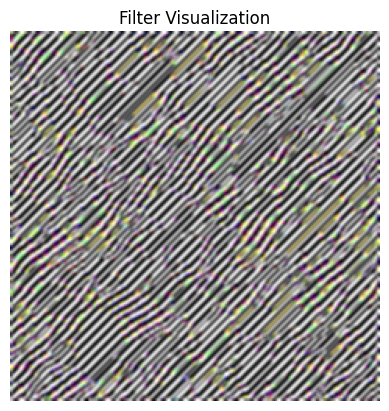

Step 0-0, Loss: -0.0893
Step 0-5, Loss: -11.2000
Step 0-10, Loss: -21.5718
Step 3-0, Loss: -6.8617
Step 3-5, Loss: -16.4441
Step 3-10, Loss: -25.6315
Step 6-0, Loss: -6.6854
Step 6-5, Loss: -16.4942
Step 6-10, Loss: -25.8413
Step 6-15, Loss: -35.1844


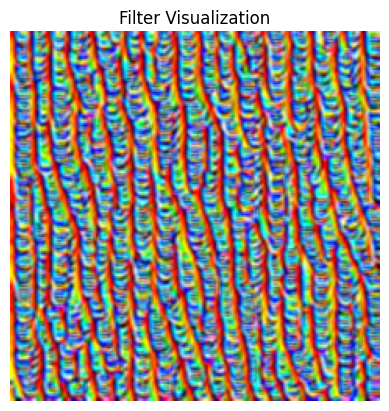

Step 0-0, Loss: -1.6612
Step 0-5, Loss: -35.2759
Step 0-10, Loss: -67.8314
Step 3-0, Loss: -23.7100
Step 3-5, Loss: -62.2581
Step 3-10, Loss: -89.4938
Step 6-0, Loss: -21.3240
Step 6-5, Loss: -62.1528
Step 6-10, Loss: -91.0609
Step 6-15, Loss: -117.4155


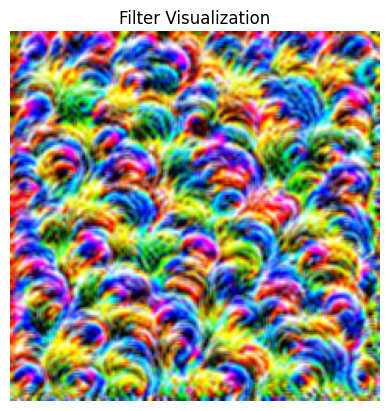

Step 0-0, Loss: -0.1158
Step 0-5, Loss: -24.5348
Step 0-10, Loss: -49.0580
Step 3-0, Loss: -15.3801
Step 3-5, Loss: -59.8251
Step 3-10, Loss: -94.8468
Step 6-0, Loss: -17.7620
Step 6-5, Loss: -64.4325
Step 6-10, Loss: -103.3148
Step 6-15, Loss: -139.0146


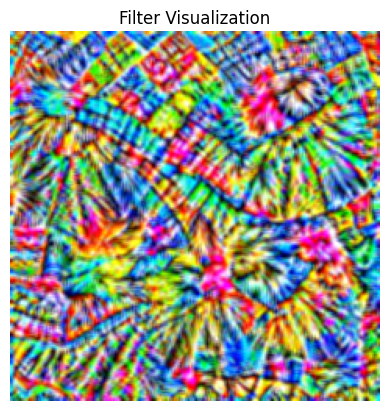

In [1]:
from fastai.vision.all import *
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models import vgg16
from torch import optim
from pathlib import Path

class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

class FilterVisualizer():
    def __init__(self):
        self.model = vgg16(weights='IMAGENET1K_V1').features.cuda().eval()
    
    def preprocess(self, img, sz):
        img = cv2.resize(img, (sz, sz), interpolation=cv2.INTER_CUBIC)
        img = np.clip(img, 0, 1)
        img = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().cuda()
        img.requires_grad_(True)
        return img

    def postprocess(self, img_tensor):
        img = img_tensor.squeeze().detach().cpu().permute(1,2,0).numpy()
        img = np.clip(img, 0, 1)
        return img

    def visualize(self, sz, layer_idx, filter_idx, upscaling_steps=12, upscaling_factor=1.2, 
                  lr=0.1, opt_steps=20, blur=None, print_losses=False):
        img = (np.random.rand(sz, sz, 3) * 0.3 + 0.5).astype(np.float32)
        layer = list(self.model.children())[layer_idx]
        activations = SaveFeatures(layer)
        
        for i in range(upscaling_steps):
            img_var = self.preprocess(img, sz)
            optimizer = optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            opt_steps_ = int(opt_steps * 1.3) if i > upscaling_steps/2 else opt_steps
            for n in range(opt_steps_):
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter_idx].mean()
                if print_losses and i % 3 == 0 and n % 5 == 0:
                    print(f"Step {i}-{n}, Loss: {loss.item():.4f}")
                loss.backward()
                optimizer.step()
            img = self.postprocess(img_var)
            sz = int(sz * upscaling_factor)
            img = cv2.resize(img, (sz, sz), interpolation=cv2.INTER_CUBIC)
            if blur: img = cv2.blur(img, (blur, blur))
        
        activations.close()
        return np.clip(img, 0, 1)

FV = FilterVisualizer()
out_img = FV.visualize(sz=56, layer_idx=2, filter_idx=5, upscaling_steps=8, opt_steps=15, blur=3, print_losses=True)
plt.imshow(out_img)
plt.axis('off')
plt.title("Filter Visualization")
plt.show()

out_img = FV.visualize(sz=56, layer_idx=9, filter_idx=5, upscaling_steps=8, opt_steps=15, blur=3, print_losses=True)
plt.imshow(out_img)
plt.axis('off')
plt.title("Filter Visualization")
plt.show()

out_img = FV.visualize(sz=56, layer_idx=18, filter_idx=5, upscaling_steps=8, opt_steps=15, blur=3, print_losses=True)
plt.imshow(out_img)
plt.axis('off')
plt.title("Filter Visualization")
plt.show()

out_img = FV.visualize(sz=56, layer_idx=25, filter_idx=5, upscaling_steps=8, opt_steps=15, blur=3, print_losses=True)
plt.imshow(out_img)
plt.axis('off')
plt.title("Filter Visualization")
plt.show()
